<a href="https://colab.research.google.com/github/filmerxyz/JSTP-22_SkinDiseaseClassificationUsingMachineLearning/blob/master/4VS123567DenseNet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
import tensorflow_addons as tfa

from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import shutil
import os
from os.path import join

# Data

In [2]:
!git clone https://github.com/EvilPickle-PCSHSPT/4VS123567_split

fatal: destination path '4VS123567_split' already exists and is not an empty directory.


In [0]:
train_path = '/content/4VS123567_split/train'
val_path = '/content/4VS123567_split/val'
test_path = '/content/4VS123567_split/test'

In [0]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
EPOCHS = 15
BATCH_SIZE = 32
NUM_CLASSES = 7
STEPS = 16

LR = 1e-5 # Learning rate

In [0]:
train_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range=360,  
                                     zoom_range = 0.3,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     fill_mode='reflect')
                                    
val_generator = ImageDataGenerator(rescale = 1./255)

test_generator = ImageDataGenerator(rescale = 1./255)

In [6]:
train_datagen = train_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                          directory=train_path,
                                          shuffle=True,
                                          target_size=(IMG_WIDTH, IMG_HEIGHT), #(224,224)
                                          class_mode='binary')

val_datagen = val_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                          directory=val_path,
                                          shuffle=True,
                                          target_size=(IMG_WIDTH, IMG_HEIGHT), #(224,224)
                                          class_mode='binary')

test_datagen = test_generator.flow_from_directory(batch_size=1,
                                          directory=test_path,
                                          shuffle=False,
                                          target_size=(IMG_WIDTH, IMG_HEIGHT), #(224,224)
                                          class_mode=None)

Found 6309 images belonging to 2 classes.
Found 2703 images belonging to 2 classes.
Found 1003 images belonging to 2 classes.


# Model

In [0]:
def buld_model():
  base_model = tf.keras.applications.DenseNet121(include_top=False, weights="imagenet", input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
  
  average_pooling_layer = GlobalAveragePooling2D()(base_model.output)

  x = tf.keras.layers.Dropout(0.3)(average_pooling_layer)
  x = tf.keras.layers.Dense(1024,activation="relu",kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
  x = tf.keras.layers.Dense(128,activation="relu",kernel_regularizer=tf.keras.regularizers.l2(0.00))(x)
  x = tf.keras.layers.Dense(64,activation="relu",kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(32,activation="relu",kernel_regularizer=tf.keras.regularizers.l2(0.00))(x)
  # tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(32,activation="relu",kernel_regularizer=tf.keras.regularizers.l2(0.000))(x)
  # tf.keras.layers.Dropout(0.3)(x)

  prediction_layer = Dense(units=1, activation='sigmoid', name='prediction')(x)

  model = Model(inputs=base_model.input, outputs=prediction_layer)

  for layer in model.layers[:-30]:
    layer.trainable=False

  return model

In [0]:
model = buld_model()

In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

## Focal Loss

In [0]:
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

In [0]:
model.compile(optimizer=Adam(LR), loss=binary_focal_loss(gamma=2., alpha=.25), metrics=['accuracy'])

In [0]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

model_checkpoint = ModelCheckpoint(filepath='densenet121_model.h5', save_best_only=True, monitor='val_loss', mode='min')

reduce_lr_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.3, min_lr=1e-5 , patience=10, verbose=1, min_delta=1e-4, mode='min')

In [27]:
history = model.fit(train_datagen,
                    validation_data=val_datagen,
                    epochs=EPOCHS,
                    callbacks=[early_stop, model_checkpoint, reduce_lr_rate],
                    verbose=1)

Epoch 1/15
198/198 [==============================] - 136s 685ms/step - loss: 0.2408 - accuracy: 0.8540 - val_loss: 0.2364 - val_accuracy: 0.8609 - lr: 1.0000e-05
Epoch 2/15
198/198 [==============================] - 132s 666ms/step - loss: 0.2330 - accuracy: 0.8558 - val_loss: 0.2296 - val_accuracy: 0.8435 - lr: 1.0000e-05
Epoch 3/15
198/198 [==============================] - 131s 662ms/step - loss: 0.2267 - accuracy: 0.8596 - val_loss: 0.2234 - val_accuracy: 0.8306 - lr: 1.0000e-05
Epoch 4/15
198/198 [==============================] - 132s 665ms/step - loss: 0.2206 - accuracy: 0.8564 - val_loss: 0.2170 - val_accuracy: 0.8568 - lr: 1.0000e-05
Epoch 5/15
198/198 [==============================] - 131s 660ms/step - loss: 0.2145 - accuracy: 0.8592 - val_loss: 0.2121 - val_accuracy: 0.8187 - lr: 1.0000e-05
Epoch 6/15
198/198 [==============================] - 131s 661ms/step - loss: 0.2085 - accuracy: 0.8656 - val_loss: 0.2064 - val_accuracy: 0.8302 - lr: 1.0000e-05
Epoch 7/15
198/198 [==

# Graph

## Accuracy

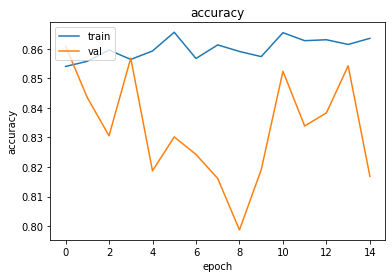

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

## Loss

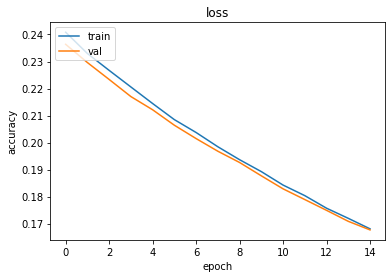

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# Evaluate

In [0]:
num_test_files = len(train_datagen.filenames)

In [0]:
test_labels = test_datagen.classes
predictions = model.predict(test_datagen, num_test_files//test_datagen.batch_size+1)

In [0]:
import itertools

In [0]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Confusion Matrix

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


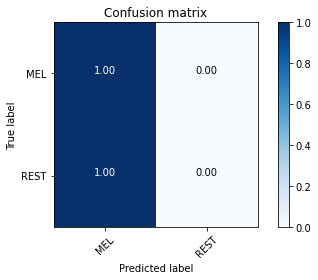

In [38]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

classes_names = ['MEL', 'REST']

plot_confusion_matrix(cm, classes_names, True)

## Classificaiton Report

In [36]:
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_labels, y_pred))
print('Classification Report')
print(classification_report(test_labels, y_pred, target_names=classes_names))

Confusion Matrix
[[112   0]
 [891   0]]
Classification Report
              precision    recall  f1-score   support

         MEL       0.11      1.00      0.20       112
        REST       0.00      0.00      0.00       891

    accuracy                           0.11      1003
   macro avg       0.06      0.50      0.10      1003
weighted avg       0.01      0.11      0.02      1003



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Grad CAM